In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.metrics import Recall, Precision, MeanIoU

In [ ]:
os.environ["PYTHONHASHSEED"] = str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
batch_size = 4
lr = 1e-4
epochs = 10
height = 768
width = 512

In [ ]:
dataset_path = os.path.join("/content/drive/MyDrive/UNET 2/dataset/non-aug")

files_dir = os.path.join("/content/drive/MyDrive/UNET 2", "files", "non-aug")
model_file = os.path.join(files_dir, "unet-non-aug.keras")
log_file = os.path.join(files_dir, "log-non-aug.h5")

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
create_dir(files_dir)

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [ ]:
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="UNET")
    return model

In [ ]:
def load_data(path):
  train_x = sorted(glob(os.path.join("/content/drive/MyDrive/UNET 2/dataset/non-aug/train/images", "*")))
  train_y = sorted(glob(os.path.join("/content/drive/MyDrive/UNET 2/dataset/non-aug/train/masks", "*")))

  valid_x = sorted(glob(os.path.join("/content/drive/MyDrive/UNET 2/dataset/non-aug/val/images", "*")))
  valid_y = sorted(glob(os.path.join("/content/drive/MyDrive/UNET 2/dataset/non-aug/val/masks", "*")))

  return (train_x, train_y), (valid_x, valid_y)

In [ ]:
def read_image(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (width, height))
  x = x/255.0
  return x

In [ ]:
def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (width, height))
  x = x/255.0
  x = np.expand_dims(x, axis=-1)
  return x

In [ ]:
def tf_parse(x, y):
  def _parse(x, y):
    x = read_image(x)
    y = read_mask(y)
    return x, y

  x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
  x.set_shape([height, width, 3])
  y.set_shape([height, width, 1])
  return x, y

In [ ]:
def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [ ]:
# def calculate_iou(original_mask, mask):
#     """Calculates the Intersection over Union (IoU) score.

#     Args:
#       original_mask: Ground truth mask.
#       mask: Predicted mask.

#     Returns:
#       The IoU score as a float.
#     """
#     # Flatten the masks
#     original_mask = original_mask.flatten()
#     mask = mask.flatten()

#     # Calculate the intersection
#     intersection = tf.math.logical_and(original_mask, mask)
#     intersection = tf.cast(intersection, tf.int32)
#     intersection_sum = tf.reduce_sum(intersection)

#     # Calculate the union
#     union = tf.math.logical_or(original_mask, mask)
#     union = tf.cast(union, tf.int32)
#     union_sum = tf.reduce_sum(union)

#     # Calculate IoU
#     iou = intersection_sum / union_sum
#     return iou

In [ ]:
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)

In [ ]:
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 1534 - 1534
Valid: 328 - 328


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [ ]:
for x, y in valid_dataset:
  print(x.shape, y.shape)

(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 3) (4, 768, 512, 1)
(4, 768, 512, 

In [ ]:
input_shape = (height, width, 3)
model = build_unet(input_shape)

In [ ]:
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 768, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 768, 512, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 768, 512, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 768, 512, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 768, 512, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 768, 512, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 768, 512, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 384, 256, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 384, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 384, 256, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 384, 256, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 384, 256, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 384, 256, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 384, 256, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 192, 128, 128)  │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 192, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc", Recall(), Precision(), MeanIoU(num_classes=2)])

In [ ]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=False)
]

In [ ]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.8040 - loss: 0.4396 - mean_io_u: 0.4049 - precision_1: 0.6261 - recall_1: 0.6468
Epoch 1: val_loss improved from inf to 0.34260, saving model to /content/drive/MyDrive/UNET 2/files/non-aug/unet-non-aug.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 771s 2s/step - acc: 0.8041 - loss: 0.4394 - mean_io_u: 0.4049 - precision_1: 0.6262 - recall_1: 0.6466 - val_acc: 0.8675 - val_loss: 0.3426 - val_mean_io_u: 0.4155 - val_precision_1: 0.8139 - val_recall_1: 0.4770 - learning_rate: 1.0000e-04
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8461 - loss: 0.3244 - mean_io_u: 0.4037 - precision_1: 0.7516 - recall_1: 0.6016
Epoch 2: val_loss improved from 0.34260 to 0.23120, saving model to /content/drive/MyDrive/UNET 2/files/non-aug/unet-non-aug.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 567s 1s/step - acc: 0.8461 - loss: 0.3243 - mean_io_u: 0.4037 - precision_1: 0.7516 - recall_1: 0.6016 - val_acc: 0.9120 - val_loss: 0.2312 - val_mean_io_u: 0.41

In [ ]:
def visualize_predictions(image, mask, prediction):

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title('Image')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Ground Truth Mask')

    axes[2].imshow(prediction, cmap='gray')
    axes[2].set_title('Predicted Mask')

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow

# Load the trained U-Net model
model = tf.keras.models.load_model("/content/drive/MyDrive/UNET 2/files/non-aug/unet-non-aug.keras")

def predict_custom_input(image_path):
  """Predicts the mask for a custom input image.

  Args:
    image_path: Path to the input image.

  Returns:
    The predicted mask as a NumPy array.
  """

  # Load and preprocess the image
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  image = cv2.resize(image, (width, height))
  image = image / 255.0
  image = np.expand_dims(image, axis=0)

  # Make the prediction
  mask = model.predict(image)

  # Post-process the mask
  mask = mask[0]  # Remove the batch dimension
  mask = np.squeeze(mask, axis=-1)  # Remove the channel dimension
  mask = (mask > 0.5).astype(np.uint8)  # Threshold the mask

  return mask

# Predict the mask
mask = predict_custom_input('/content/drive/MyDrive/Sorghum Disease Image Dataset/Rust/Rust530.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
input_image = plt.imread('/content/drive/MyDrive/Sorghum Disease Image Dataset/Rust/Rust530.jpg')
original_mask = plt.imread('/content/drive/MyDrive/Rust_mask/Rust530.png')

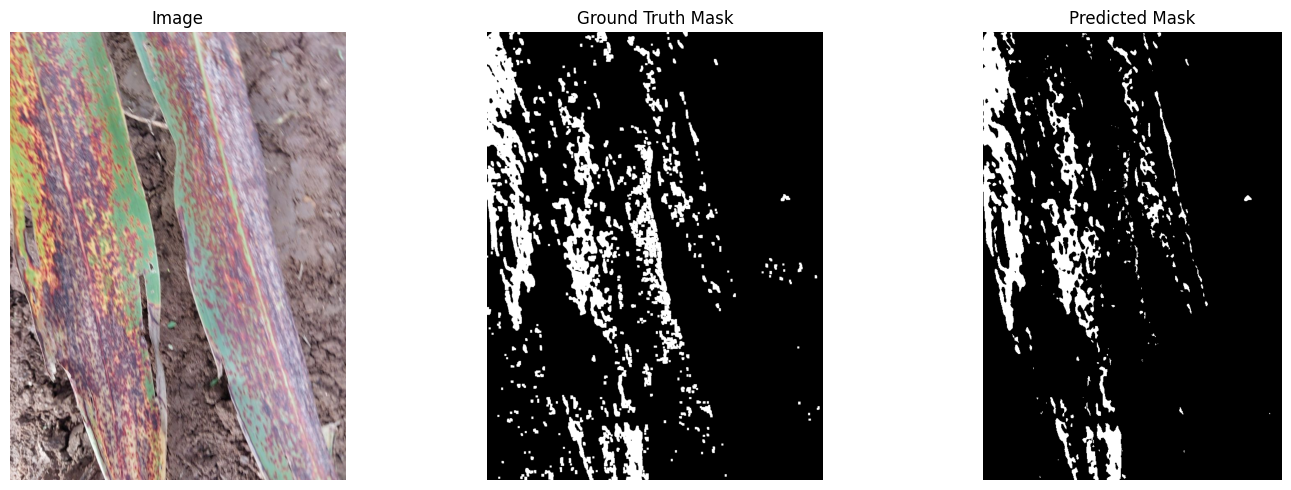

In [ ]:
visualize_predictions(input_image, original_mask, mask)